# imports..

In [1]:
from research.research_engine import build_ResearchEngine
from strategies.vault_betsizing import YieldStrategy
from strategies.vault_backtest import VaultBacktestEngine
import json
import yaml
import numpy as np
import pandas as pd
from copy import deepcopy
import warnings
warnings.filterwarnings(action='once')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
strategies =[
  - "42c02674-f7a2-4cb0-be3d-ade268838770" # balancer-v2_RETH-WETH
  - "4cc5df76-f81d-49fe-9e1e-4caa6a8dad0b" # balancer-v2_WSTETH-WETH
  - "5ce23e7e-3800-4c9c-ad30-6db3db0515a1" # convex-finance_ETH-STETH
  - "747c1d2a-c668-4682-b9f9-296708a3dd90" # lido_STETH
  - "77020688-e1f9-443c-9388-e51ace15cc32" # frax-ether_SFRXETH
  - "c9873dab-0979-478c-b48c-3c3a0c935449" # convex-finance_STETH-FRXETH
  - "d4b3c522-6127-4b89-bedf-83641cdcd2eb" # rocket-pool_RETH
  - "e378a7c2-6285-4993-9397-87ac9c8adc15" # convex-finance_ETH-STETH
  - "e6435aae-cbe9-4d26-ab2c-a4d533db9972" # aave-v3_WSTETH
  - "f1a22245-a1f1-4389-8ff2-dde4914b272d" # aave-v3_RETH
  - "fc7701fc-e290-4606-a8be-9e4ba6c5f91a" # convex-finance_ETH-RETH
]

# load data

In [3]:
vault = 'DynLst'
metadata = pd.read_csv(f"C:/Users/david/singularity/midfreq/scrappers/defillama_history/data/{vault}_pool_metadata.csv")
with open(f"C:/Users/david/singularity/midfreq/config/{vault.lower()}.yaml") as file:
    parameters= yaml.safe_load(file)
pool_map = metadata.loc[metadata['pool'].isin(parameters['input_data']['selected_instruments']),['pool','project','symbol']].set_index('pool').T.to_dict()
pool_map = {key: '{}_{}'.format(x['project'], x['symbol']) for key, x in pool_map.items()}
index_map = {f'weight_{i}': f'w_{value}' for i, value in enumerate(pool_map.values())}
index_map |= {f'yield_{i}': f'y_{value}' for i, value in enumerate(pool_map.values())} 
with open(f"C:/Users/david/singularity/midfreq/config/{vault.lower()}.yaml", 'r') as fp:
    parameters = yaml.safe_load(fp)

C:\Users\david\singularity\midfreq\venv\lib\site-packages\pandas\core\algorithms.py:518: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

C:\Users\david\singularity\midfreq\venv\lib\site-packages\pandas\core\algorithms.py:518: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



### naive optimization - no swap_cost

In [4]:
parameter_grid = {"cap": 9,
                  "halflife": "1s",
                  "cost": 0.0001,
                  "gaz": False,
                  "assumed_holding_days": 9999,
                  "base_buffer": 0.15,
                  "concentration_limit": 1.0}
filename = "C:/Users/david/singularity/midfreq/logs/{}/{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(vault.lower(), *parameter_grid.values())
backtest = pd.read_csv(filename, header=[0,1])

In [5]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

print(filename)
apy.mean()

C:/Users/david/singularity/midfreq/logs/dynlst/9_1s_0.0001_False_9999_0.15_1.0__backtest.csv


7.8851296648553815

C:/Users/david/singularity/midfreq/logs/dynlst/9_1s_0.0001_False_9999_0.15_1.0__backtest.csv


7.8851296648553815

### naive optimization - 10bps swap_cost

In [36]:
parameter_grid = {"cap": 9,
                  "halflife": "1s",
                  "cost": 0.001,
                  "gaz": False,
                  "assumed_holding_days": 9999,
                  "base_buffer": 0.15,
                  "concentration_limit": 1.0}
filename = "C:/Users/david/singularity/midfreq/logs/{}/{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(vault.lower(), *parameter_grid.values())
backtest = pd.read_csv(filename, header=[0,1])

In [44]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

print(filename)
apy.mean()

C:/Users/david/singularity/midfreq/logs/dynlst/9_1s_0.001_False_28_0.15_1.0__backtest.csv


C:/Users/david/singularity/midfreq/logs/dynlst/9_1s_0.001_False_28_0.15_1.0__backtest.csv


5.664684475516691

5.664684475516691

### cost aware optimization (28d holding)

In [60]:
parameter_grid = {"cap": 9,
                  "halflife": "1s",
                  "cost": 0.001,
                  "gaz": False,
                  "assumed_holding_days": 28,
                  "base_buffer": 0.15,
                  "concentration_limit": 1.0}
filename = "C:/Users/david/singularity/midfreq/logs/{}/{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(vault.lower(), *parameter_grid.values())
backtest = pd.read_csv(filename, header=[0,1])

In [61]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

print(filename)
apy.mean()

C:/Users/david/singularity/midfreq/logs/dynlst/9_1s_0.001_False_28_0.15_1.0__backtest.csv


C:/Users/david/singularity/midfreq/logs/dynlst/9_1s_0.001_False_28_0.15_1.0__backtest.csv


5.664684475516691

5.664684475516691

### cost aware smoothed (3d) optimization (28d holding)

In [62]:
parameter_grid = {"cap": 9,
                  "halflife": "3d",
                  "cost": 0.001,
                  "gaz": False,
                  "assumed_holding_days": 28,
                  "base_buffer": 0.15,
                  "concentration_limit": 1.0}
filename = "C:/Users/david/singularity/midfreq/logs/{}/{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(vault.lower(), *parameter_grid.values())
backtest = pd.read_csv(filename, header=[0,1])

In [63]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

print(filename)
apy.mean()

C:/Users/david/singularity/midfreq/logs/dynlst/9_3d_0.001_False_28_0.15_1.0__backtest.csv


C:/Users/david/singularity/midfreq/logs/dynlst/9_3d_0.001_False_28_0.15_1.0__backtest.csv


7.260456816528662

7.260456816528662

# heatmaps

In [13]:
parameter_grid = {"cap": [0.2, 9],
                  "halflife": ["1s", "3d", "10d", "30d"],
                  "cost": [0.0001, 0.0005, 0.001, 0.005],
                  "gaz": [False],
                  "assumed_holding_days": [3, 8, 13, 18, 23, 28, 32, 9999],
                  "base_buffer": [0.15],
                  "concentration_limit": [0.4,
                                          0.7, 1.0]}

In [25]:
grid = pd.read_csv(f"C:/Users/david/singularity/midfreq/logs/{vault.lower()}/grid.csv", index_col=0)
grid['tx_cost'].iloc[0] = 0.001
grid = grid.rename(columns={'cost': 'swap_cost'})
all_index = {col: grid[col].unique() for col in grid.columns}
print(grid.columns)

grid['churn in d'] = grid.apply(lambda x: 2 * 365 * x['swap_cost']/x['tx_cost']/100, axis=1)

format_dict = {key: (lambda x: x) for key in grid.columns}
format_dict['perf'] = lambda x: f'{x:.1%}'
format_dict['tx_cost'] = lambda x : f'{x:.0f}'
format_dict['avg_entropy'] = lambda x: f'{x:.0%}'

def display_heatmap(metrics, ind, col, filtering):
    fig = plt.figure(figsize = (20,20)) # width x height
    
    # filter
    filtered_grid = grid[np.logical_and.reduce([
            grid[filter_c]==filter_v
        for filter_c, filter_v in filtering.items()])]
    
    # pivot and display
    for i, values in enumerate(metrics):
        for j, column in enumerate(col):
            df = filtered_grid.pivot_table(values=values, index=ind, columns=col)*100
            ax = fig.add_subplot(len(col), len(metrics), i+j+1)
            ax.set_title(f'{values} by {column}')
            sns.heatmap(data=df, ax=ax, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})

Index(['cap', 'halflife', 'swap_cost', 'gaz', 'assumed_holding_days',
       'base_buffer', 'concentration_limit', 'perf', 'tx_cost', 'avg_entropy'],
      dtype='object')
Index(['cap', 'halflife', 'swap_cost', 'gaz', 'assumed_holding_days',
       'base_buffer', 'concentration_limit', 'perf', 'tx_cost', 'avg_entropy'],
      dtype='object')


C:\Users\david\singularity\midfreq\venv\lib\site-packages\pandas\core\algorithms.py:518: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

C:\Users\david\singularity\midfreq\venv\lib\site-packages\pandas\core\algorithms.py:518: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



## churn vs     activeness / predictor halflife -> halflife = 10d horizon = ~4w

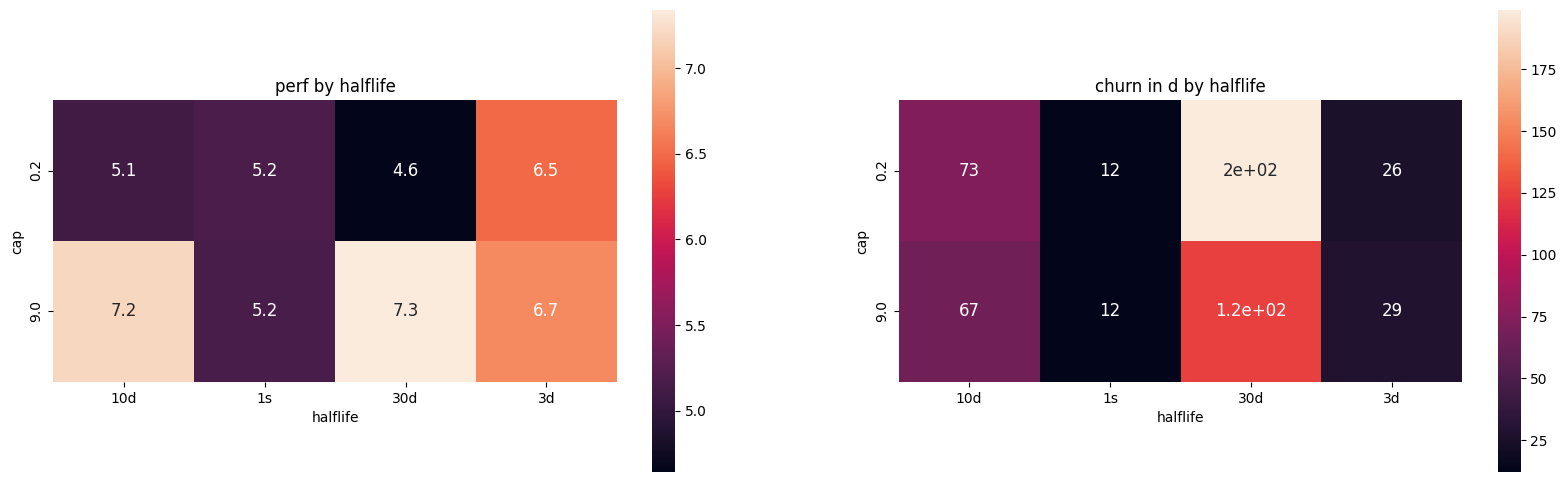

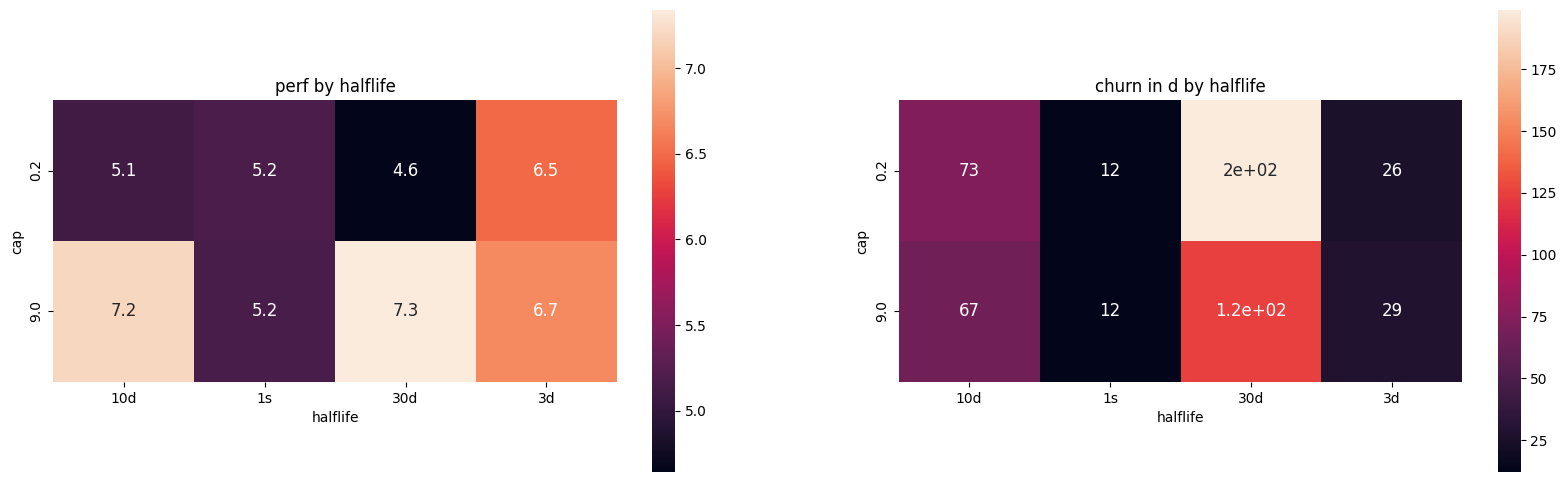

In [53]:
metrics = ['perf', 'churn in d']
ind = ['cap']
col = ['halflife']
filtering = {
#    'cap': 9,
#    'halflife': "30d",
    'swap_cost': 5e-4,
    'gaz': False,
    'assumed_holding_days': 32,
    'base_buffer': 0.15,
    'concentration_limit': 0.7,
}
display_heatmap(metrics, ind, col, filtering)

## entropy vs     concentration x activeness

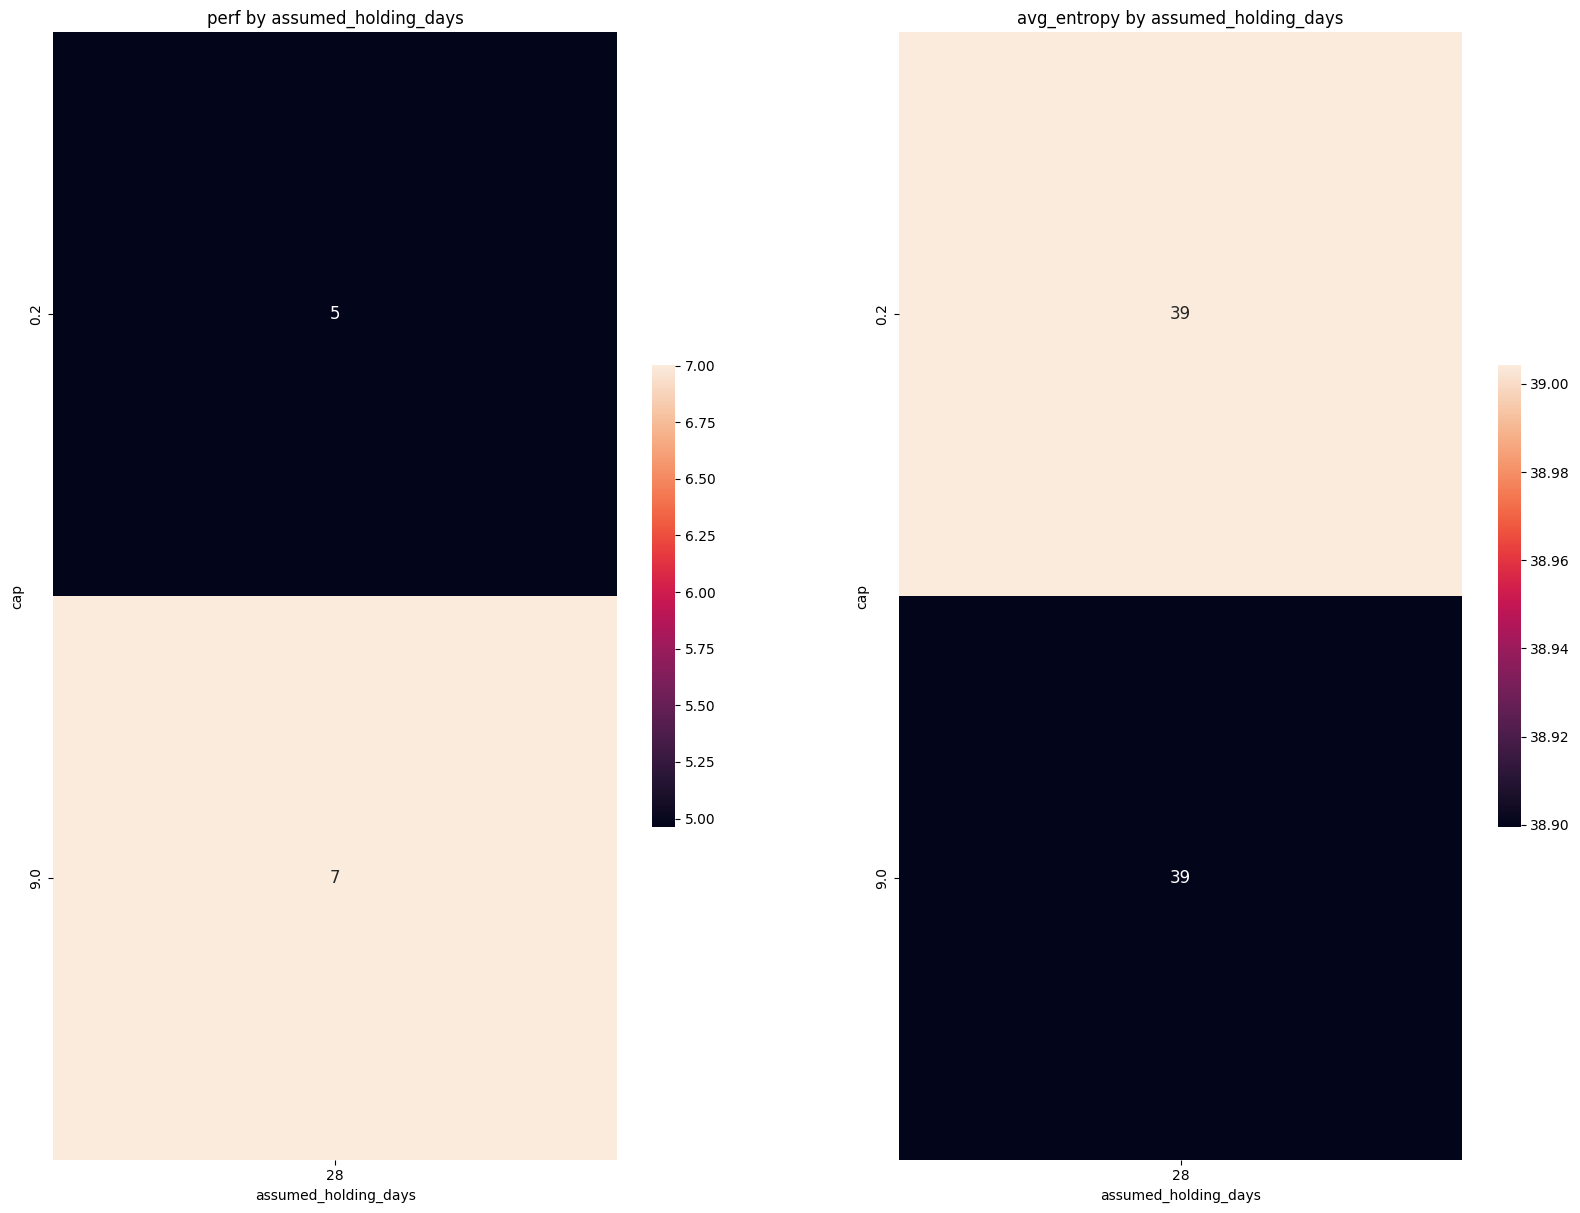

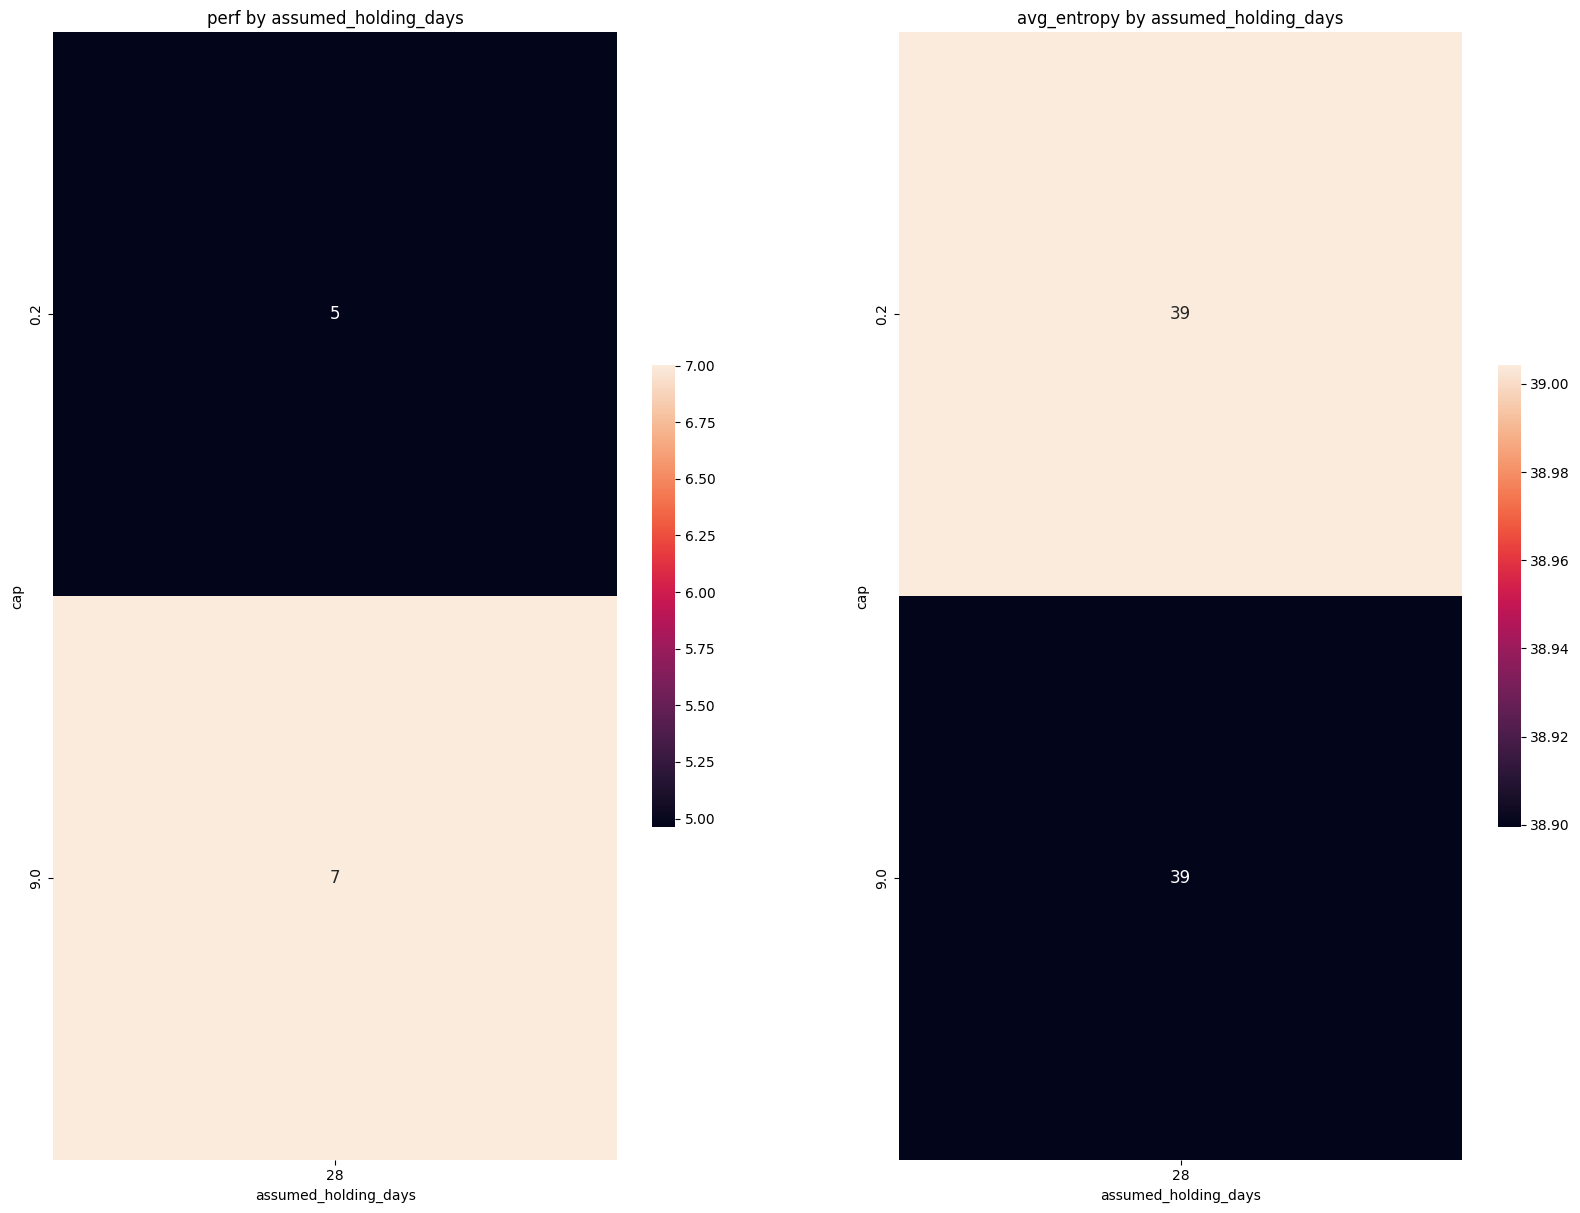

In [52]:
filtering = {
#    'cap': 0.2,
    'halflife': '10d',
    'swap_cost': 5e-4,
    'gaz': False,
    'assumed_holding_days': 28,
    'base_buffer': 0.15,
#    'concentration_limit': 0.4,
}
metrics = ['perf', 'avg_entropy']
ind = ['cap']
col = ['assumed_holding_days']
display_heatmap(metrics, ind, col, filtering)